## Package Imports

In [1]:
import pandas as pd
import xplainable as xp
from xplainable.core.models import XClassifier
from xplainable.core.optimisation.bayesian import XParamOptimiser
from xplainable.preprocessing.pipeline import XPipeline
from xplainable.preprocessing import transformers as xtf
from sklearn.model_selection import train_test_split
import requests

import xplainable_client
import json
from xplainable.visualisation import create_waterfall_plot

/Users/jtuppack/miniforge3/envs/xplainable-jupyter/lib/python3.10/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Instantiate Xplainable Cloud

Initialise the xplainable cloud using an API key from:
https://platform.xplainable.io/

This allows you to save and collaborate on models, create deployments, create shareable reports.

In [3]:
client = xplainable_client.Client(
    api_key="167af6b8-731b-455c-9201-0a245faf6b3c",#<- Add your own token here
    hostname="https://xplainable-api-uat-itdcj.ondigitalocean.app/"
)

## Read IBM Telco Churn Dataset

In [4]:
df = pd.read_csv('https://xplainable-public-storage.syd1.digitaloceanspaces.com/example_data/telco_customer_churn.csv')

### Sample of the IBM Telco Churn Dataset

In [5]:
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,No,Month-to-month,Yes,Mailed check,53.85,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,No,Month-to-month,Yes,Electronic check,70.70,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,Month-to-month,Yes,Electronic check,99.65,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Yes,Month-to-month,Yes,Electronic check,104.80,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,Yes,1,89,5340,Competitor had better devices


## 1. Data Preprocessing

### Turn Label into Binary input

In [6]:
df["Churn Label"] = df["Churn Label"].map({"Yes":1,"No":0})

In [7]:
#Instantiate a Pipeline
pipeline = XPipeline()

# Add stages for specific features
pipeline.add_stages([
    {"transformer": xtf.ChangeCases(
        columns=['City', 'Gender', 'Senior Citizen', 'Partner', 'Dependents',
       'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method'], case="lower")},
    {"feature":"City","transformer": xtf.Condense(pct=0.25)}, #-> Automatically condense extremely long tail values, to check if latent information
    {"feature":"Monthly Charges", "transformer": xtf.SetDType(to_type="float")}, #-> Turn values into float
    {"transformer": xtf.DropCols(
        columns=['CustomerID', #-> Highly Cardinal, 
                 "Total Charges", #-> Reduce Multicollinearity between Tenure and Monthly Costs
                 'Count', #-> Only one value
                 "Country", #-> Only one value
                 "State", #-> Only one value,
                 "Zip Code", #-> Highly Cardinal and Data Leakage if you keep City
                 "Lat Long", #-> Highly Cardinal
                 "Latitude", #-> Highly Cardinal
                 "Longitude", #-> Highly Cardinal
                 "Churn Value", #-> Data Leakage
                 "Churn Score", #-> Data Leakage
                 "CLTV", #-> Data Leakage
                 "Churn Reason", #-> Data Leakage
                ]
    )},
])

### Preprocessed data

In [8]:
df_transformed = pipeline.fit_transform(df)
df_transformed.head()

,City,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Churn Label
0,los angeles,male,no,no,no,2,yes,no,dsl,yes,yes,no,no,no,no,month-to-month,yes,mailed check,53.85,1
1,los angeles,female,no,no,yes,2,yes,no,fiber optic,no,no,no,no,no,no,month-to-month,yes,electronic check,70.70,1
2,los angeles,female,no,no,yes,8,yes,yes,fiber optic,no,no,yes,no,yes,yes,month-to-month,yes,electronic check,99.65,1
3,los angeles,female,no,yes,yes,28,yes,yes,fiber optic,no,no,yes,yes,yes,yes,month-to-month,yes,electronic check,104.80,1
4,los angeles,male,no,no,yes,49,yes,yes,fiber optic,no,yes,yes,no,yes,yes,month-to-month,yes,bank transfer (automatic),103.70,1


### Create Preprocessor to Persist to Xplainable Cloud

In [9]:
preprocessor_id, version_id = client.create_preprocessor(
    preprocessor_name="Telco Churn Preprocessing - 5",
    preprocessor_description="Handling all preprocessing steps in the IBM Telco Churn Dataset",
    pipeline=pipeline,
    df=df
)

<Response [200]>


### Loading the Preprocessor steps
Use the api to load pre-existing preprocessor steps from the xplainable cloud and transform data inplace.

In [10]:
pp_cloud = client.load_preprocessor(
    preprocessor_id,
    version_id
)

<Response [200]>


In [11]:
pp_cloud.stages

[{'feature': '__dataset__',
  'name': 'ChangeCases',
  'transformer': <xplainable.preprocessing.transformers.dataset.ChangeCases at 0x28d263e80>},
 {'feature': 'City',
  'name': 'Condense',
  'transformer': <xplainable.preprocessing.transformers.categorical.Condense at 0x28d0a1c90>},
 {'feature': 'Monthly Charges',
  'name': 'SetDType',
  'transformer': <xplainable.preprocessing.transformers.mixed.SetDType at 0x28d0727a0>},
 {'feature': '__dataset__',
  'name': 'DropCols',
  'transformer': <xplainable.preprocessing.transformers.dataset.DropCols at 0x28d071db0>}]

In [12]:
df_transformed_cloud = pp_cloud.transform(df)

### Create Train/Test split for model training validation

In [13]:
X, y = df_transformed_cloud.drop(columns=['Churn Label']), df['Churn Label']

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)

## 2. Model Optimisation
The `XParamOptimiser` is utilised to fine-tune the hyperparameters of our model. This process searches for the optimal parameters that will yield the best model performance, balancing accuracy and computational efficiency.

In [14]:
opt = XParamOptimiser()
params = opt.optimise(X_train, y_train)

100%|██████████| 30/30 [00:02<00:00, 11.47trial/s, best loss: -0.7956806571954382]


## 3. Model Training
With the optimised parameters obtained, the `XClassifier` is trained on the dataset. This classifier undergoes a fitting process with the training data, ensuring that it learns the underlying patterns and can make accurate predictions.

In [15]:
model = XClassifier(**params)
model.fit(X_train, y_train)

## 4. Model Interpretability and Explainability
Following training, the `model.explain()` method is called to generate insights into the model's decision-making process. This step is crucial for understanding the factors that influence the model's predictions and ensuring that the model's behaviour is transparent and explainable.

In [16]:
model.explain()

alt.HConcatChart(...)

The image displays two graphs related to a churn prediction model.

On the left is the 'Feature Importances' bar chart, which ranks the features by their ability to predict customer churn. 'Tenure Months' has the highest importance, confirming that the length of customer engagement is the most significant indicator of churn likelihood. 'Monthly Charges' and 'Contract' follow, suggesting that financial and contractual commitments are also influential in churn prediction.

The right graph is a 'Contributions' histogram, which quantifies the impact of a specific feature's values on the prediction outcome. The red bars indicate that higher values within the selected feature correspond to a decrease in the likelihood of churn, whereas the green bars show that lower values increase this likelihood.

The placement of 'Gender' at the bottom of the 'Feature Importances' chart conclusively indicates that the model does not consider gender a determinant in predicting churn, thereby ensuring the model's impartiality regarding gender.


## 5. Model Persisting
In this step, we first create a unique identifier for our churn prediction model using `client.create_model_id`. This identifier, shown as `model_id`, represents the newly instantiated model which predicts the likelihood of customers leaving within the next month. Following this, we generate a specific version of the model with `client.create_model_version`, passing in our training data. The output `version_id` represents this particular iteration of our model, allowing us to track and manage different versions systematically.


In [17]:
# Create a model
model_id = client.create_model(
    model=model,
    model_name="Autotrain Telco Churn",
    model_description="Predicting customers who are likely to leave the business within the next month.",
    x=X_train,
    y=y_train
)

  0%|          | 0/19 [00:00<?, ?it/s]

<Response [200]>


### SaaS Models View

![Model Image](https://xplainable-public-storage.syd1.digitaloceanspaces.com/documentation_content/models.png)

### SaaS Explainer View

![Model Image](https://xplainable-public-storage.syd1.digitaloceanspaces.com/documentation_content/model_explainer.png)

## 6. Model Deployment

The code block illustrates the deployment of our churn prediction model using the `xp.client.deploy` function. The deployment process involves specifying the `hostname` of the server where the model will be hosted, as well as the unique `model_id` and `version_id` that we obtained in the previous steps. This step effectively activates the model's endpoint, allowing it to receive and process prediction requests. The output confirms the deployment with a `deployment_id`, indicating the model's current `status` as 'inactive', its `location`, and the `endpoint` URL where it can be accessed for xplainable deployments.


In [18]:
deployment = client.deploy(
    model_version_id=model_id["version_id"] #<- Use version id produced above
)

<Response [200]>


### SaaS Deployment View

![Model Image](https://xplainable-public-storage.syd1.digitaloceanspaces.com/documentation_content/deployments.png)


### Testing the Deployment programatically
This section demonstrates the steps taken to programmatically test a deployed model. These steps are essential for validating that the model's deployment is functional and ready to process incoming prediction requests.


1. **Activating the Deployment:**
   The model deployment is activated using `client.activate_deployment`, which changes the deployment status to active, allowing it to accept prediction requests.

In [19]:
client.activate_deployment(deployment['deployment_id'])

{'message': 'activated deployment'}

2. **Creating a Deployment Key:**
   A deployment key is generated with `client.generate_deploy_key`. This key is required to authenticate and make secure requests to the deployed model.

In [20]:
deploy_key = client.generate_deploy_key(deployment['deployment_id'], 'Deployment API for Telco Churn', 7)

<Response [200]>


3. **Generating Example Payload:**
   An example payload for a deployment request is generated by `client.generate_example_deployment_payload`. This payload mimics the input data structure the model expects when making predictions.

In [21]:
#Set the option to highlight multiple ways of creating data
option = 2

In [22]:
if option == 1:
    body = client.generate_example_deployment_payload(deployment['deployment_id'])
else:
    body = json.loads(df_transformed.drop(columns=["Churn Label"]).sample(1).to_json(orient="records"))
    body[0]["Gender"] = None #<- Won't require this line the next release of xplainable

In [23]:
body

[{'City': 'other',
  'Gender': None,
  'Senior Citizen': 'no',
  'Partner': 'yes',
  'Dependents': 'no',
  'Tenure Months': 58,
  'Phone Service': 'yes',
  'Multiple Lines': 'yes',
  'Internet Service': 'dsl',
  'Online Security': 'yes',
  'Online Backup': 'no',
  'Device Protection': 'yes',
  'Tech Support': 'yes',
  'Streaming TV': 'yes',
  'Streaming Movies': 'yes',
  'Contract': 'two year',
  'Paperless Billing': 'yes',
  'Payment Method': 'electronic check',
  'Monthly Charges': 84.3}]

4. **Making a Prediction Request:**
   A POST request is made to the model's prediction endpoint with the example payload. The model processes the input data and returns a prediction response, which includes the predicted class (e.g., 'No' for no churn) and the prediction probabilities for each class.

In [24]:
response = requests.post(
    url="https://inference.xplainable.io/v1/predict",
    headers={'api_key': deploy_key['deploy_key']},
    json=body
)

value = response.json()
value

[{'index': 0,
  'id': None,
  'partition': '__dataset__',
  'score': 0.4124611343175905,
  'proba': None,
  'pred': 0,
  'support': None,
  'breakdown': [{'feature': 'base_value',
    'value': None,
    'score': 0.2602797795676134},
   {'feature': 'City', 'value': 'other', 'score': 0.0},
   {'feature': 'Gender', 'value': 'nan', 'score': 0.0},
   {'feature': 'Senior Citizen', 'value': 'no', 'score': 0.0},
   {'feature': 'Partner', 'value': 'yes', 'score': 0.0},
   {'feature': 'Dependents', 'value': 'no', 'score': 0.0},
   {'feature': 'Tenure Months', 'value': '58', 'score': -0.0939361638747209},
   {'feature': 'Phone Service', 'value': 'yes', 'score': 0.0},
   {'feature': 'Multiple Lines', 'value': 'yes', 'score': 0.0},
   {'feature': 'Internet Service', 'value': 'dsl', 'score': 0.0},
   {'feature': 'Online Security', 'value': 'yes', 'score': 0.0},
   {'feature': 'Online Backup', 'value': 'no', 'score': 0.0},
   {'feature': 'Device Protection', 'value': 'yes', 'score': 0.0},
   {'featur

In [2]:
value = [{'index': 0,
  'id': None,
  'partition': '__dataset__',
  'score': 0.4124611343175905,
  'proba': None,
  'pred': 0,
  'support': None,
  'breakdown': [{'feature': 'base_value',
    'value': None,
    'score': 0.2602797795676134},
   {'feature': 'City', 'value': 'other', 'score': 0.0},
   {'feature': 'Gender', 'value': 'nan', 'score': 0.0},
   {'feature': 'Senior Citizen', 'value': 'no', 'score': 0.0},
   {'feature': 'Partner', 'value': 'yes', 'score': 0.0},
   {'feature': 'Dependents', 'value': 'no', 'score': 0.0},
   {'feature': 'Tenure Months', 'value': '58', 'score': -0.0939361638747209},
   {'feature': 'Phone Service', 'value': 'yes', 'score': 0.0},
   {'feature': 'Multiple Lines', 'value': 'yes', 'score': 0.0},
   {'feature': 'Internet Service', 'value': 'dsl', 'score': 0.0},
   {'feature': 'Online Security', 'value': 'yes', 'score': 0.0},
   {'feature': 'Online Backup', 'value': 'no', 'score': 0.0},
   {'feature': 'Device Protection', 'value': 'yes', 'score': 0.0},
   {'feature': 'Tech Support', 'value': 'yes', 'score': 0.0},
   {'feature': 'Streaming TV', 'value': 'yes', 'score': 0.0},
   {'feature': 'Streaming Movies', 'value': 'yes', 'score': 0.0},
   {'feature': 'Contract', 'value': 'two year', 'score': 0.0},
   {'feature': 'Paperless Billing', 'value': 'yes', 'score': 0.0},
   {'feature': 'Payment Method', 'value': 'electronic check', 'score': 0.0},
   {'feature': 'Monthly Charges',
    'value': '84.3',
    'score': 0.24611751862469802}]}]

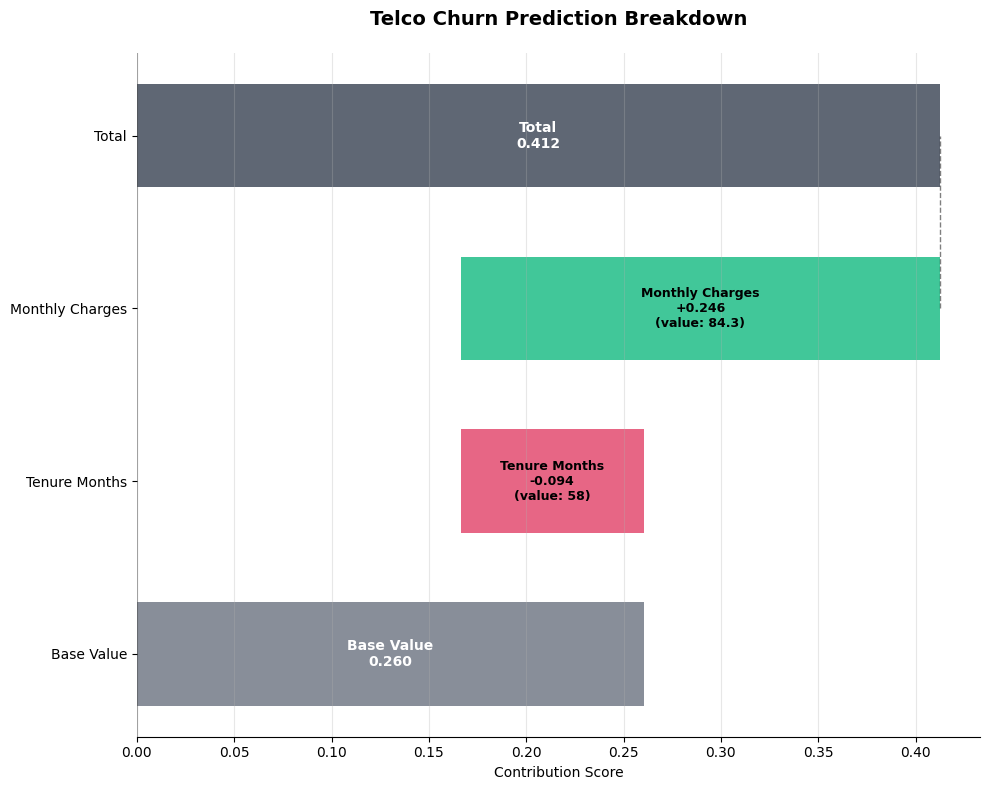

In [ ]:
# Use your API response data (the 'value' variable from your screenshot)
fig = create_waterfall_plot(value, title="Telco Churn Prediction Breakdown")

## SaaS Deployment Info
The SaaS application interface displayed above mirrors the operations performed programmatically in the earlier steps. It displays a dashboard for managing the 'Telco Customer Churn' model, facilitating a range of actions from deployment to testing, all within a user-friendly web interface. This makes it accessible even to non-technical users who prefer to manage model deployments and monitor performance through a graphical interface rather than code. Features like the deployment checklist, example payload, and prediction response are all integrated into the application, ensuring that users have full control and visibility over the deployment lifecycle and model interactions.

![Model Image](https://xplainable-public-storage.syd1.digitaloceanspaces.com/documentation_content/deployment_info.png)



## 7. Batch Optimisation (Beta)
The concept of Batch Optimization within the Xplainable platform represents a significant leap forward from traditional machine learning approaches. Moving away from the prediction -> monitor model approach, this feature offers a dynamic and cost-effective utilisation of model insights.

This optimisation approach allows for the association of monetary costs with various predictive scores. It provides a detailed understanding of the financial impact of different predictive outcomes. For example, within our Telco model, the choice to provide tech support carries a different cost implication than opting against it, influencing the decision-making process.

Features may be fixed or adjustable to align with business requirements. Certain attributes like 'Senior Citizen', 'Tenure', and 'Monthly Charges' may be set due to regulatory standards or business limitations, ensuring that optimisation adheres to these rules.

Conversely, features such as 'Streaming Movies' or 'Device Protection' are modifiable, enabling the exploration of various combinations to discover the most cost-effective approach. The model could assess if altering the contract type for specific customer segments improves retention without markedly raising costs.

Employing the Xplainable model's output in this manner allows organisations to extend past simple predictions to genuine cost optimisation, facilitating strategic decision-making that evaluates each recommended action not only for its impact on outcomes like churn but also for cost-efficiency. Thus, Xplainable's strategy provides businesses the capability to optimise their resources with foresight rarely seen in traditional machine learning.

